# Import libraries

In [1]:
import os
import sys
import glob
import datetime

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import importlib
from process_frames import Processor

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)
    import pandas as pd
    from tqdm import tqdm
    tqdm.pandas()
from IPython.display import display
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, LassoLars, LassoLarsCV
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor 
from sklearn.tree import DecisionTreeRegressor
import joblib
import seaborn as sn

# Choose options
If you want to process image, set PROCESS_IMAGES to True
If you want to process data, set PROCESS_DATA to True

In [2]:
PROCESS_IMAGES = True
PROCESS_DATA = True

# List images

In [3]:
path = os.getcwd()
os.chdir(path)
sys.path.append(path)
sys.path.append(os.path.join(path, 'scripts'))

path_color = '../data/color/'
path_depth = '../data/depth/'
path_mosaic = '../data/mosaic/'

#Create mosaic path if it not exits
if (not os.path.isdir(path_mosaic)):
    os.mkdir(path_mosaic)

file_list = glob.glob(path_depth+"*")
file_list = [os.path.basename(filename) for filename in file_list]

print(len(file_list),"images found")

2069 images found


# Generate data

In [4]:
if PROCESS_IMAGES:
    processor = Processor()
    areas = {filename: processor.process_image(depth_filename=os.path.join(path_depth, filename),
                          color_filename=os.path.join(path_color, filename),
                          mosaic_path=path_mosaic) for filename in file_list}
    # Prepare data
    remove_areas = []
    for area in areas:    
        if areas[area] is None:  
            remove_areas.append(area)
    for remove in remove_areas:
        del areas[remove]
    areas_dataframe = pd.DataFrame.from_dict(areas, orient='index',
         columns=['area', 'x', 'y', 'width', 'height', 'MA', 'ma', 'centroid_x', 'centroid_y', 'orientation', '% area', 'center distance', 'eccentricity', 'perimeter', 'symmetry'])
    areas_dataframe.index.name = 'uuid'
    areas_dataframe.index = areas_dataframe.index.str.replace('.npy', '',)
    print("Generated data")
    display(areas_dataframe.head())
    # Read csv file with weights
    weight_data = pd.read_csv(os.path.join("..", 'data', 'id_weight_sex_uuid.csv'), usecols=['uuid', 'id', 'sex', 'weight'])
    print("Loaded data")
    display(weight_data.head())
    # Save calculated information in csv file
    mix = pd.merge(weight_data, areas_dataframe, on='uuid', how='inner')
    weight_col = mix.pop('weight')
    x_col = mix.pop('x')
    y_col = mix.pop('y')
    centroid_x_col = mix.pop('centroid_x')
    centroid_y_col = mix.pop('centroid_y')
    orientation_col = mix.pop('orientation')
    center_dist_col = mix.pop('center distance')
    mix.insert(12, 'weight', weight_col)
    mix.insert(13, 'x', x_col)
    mix.insert(14, 'y', y_col)
    mix.insert(15, 'centroid_x', centroid_x_col)
    mix.insert(16, 'centroid_y', centroid_y_col)
    mix.insert(17, 'center distance', center_dist_col)
    mix.insert(18, 'orientation', orientation_col)
    mix.to_csv(os.path.join("..", 'data', 'id_weight_sex_uuid_data.csv'))
    print("Final data")
    display(mix.head())

Generated data


,area,x,y,width,height,MA,ma,centroid_x,centroid_y,orientation,% area,center distance,eccentricity,perimeter,symmetry
uuid,,,,,,,,,,,,,,,
0018b76693a14e20bce3027ff67dc055,273025.289744,196,119,576,346,563.124084,304.146881,258.377880,474.895100,-1.348229,50.015605,54.111530,0.841597,1727.474300,0.258794
00607e166c6e4054ab75451aacfbe32d,265083.619523,186,118,592,339,574.335022,307.100464,257.150605,476.758842,-1.407047,51.423913,55.476469,0.845038,1757.658066,0.264058
00635ae09a834ebf86ee85c58c12ff82,201016.798552,109,108,565,245,523.746887,250.569244,235.902665,407.500741,-1.551654,49.959682,17.000402,0.878133,1552.628628,0.170682
0066778f47734ca7a71be790f562c551,271063.185330,195,120,578,344,563.428528,306.356812,259.034342,475.183414,-1.366295,50.484331,54.608132,0.839256,1733.131154,0.262357
006d8cf500f14647a8de9ecf71951066,194461.430407,203,77,441,359,504.326263,214.100098,249.268163,400.243665,-1.016888,41.053033,25.500242,0.905415,1436.261097,0.274467


Loaded data


,uuid,id,sex,weight
0,3b144fdfdb9f4e02b0f65aed674fbd72,0268,1,24.5
1,960fd92c91f541f6b85889426c39a0fe,0261,1,27.1
2,ca10f050724d47f5971c3530ef341a8d,0236,0,25.5
3,3c4dcc3c6d83425dab0d0acd75227f99,0236,0,25.5
4,46d3f67bbf684992ac945ce7c1991ae7,0238,1,25.8


Final data


,uuid,id,sex,area,width,height,MA,ma,% area,eccentricity,perimeter,symmetry,weight,x,y,centroid_x,centroid_y,center distance,orientation
0,3b144fdfdb9f4e02b0f65aed674fbd72,0268,1,292877.074890,564,312,589.829285,226.871475,46.219501,0.923067,1797.356550,0.278912,24.5,103,105,291.266698,390.794758,61.080786,-1.305798
1,960fd92c91f541f6b85889426c39a0fe,0261,1,308998.472633,648,256,681.104919,217.185989,58.533350,0.947797,1741.817446,0.325646,27.1,80,202,328.944662,427.000459,88.995256,1.441417
2,ca10f050724d47f5971c3530ef341a8d,0236,0,292174.501116,569,324,671.221436,167.003387,36.034621,0.968554,1568.812394,0.269251,25.5,195,103,270.915334,489.139166,72.103182,1.183508
3,46d3f67bbf684992ac945ce7c1991ae7,0238,1,274668.662187,613,210,637.330017,188.982895,60.039439,0.955026,1589.508790,0.367365,25.8,117,181,288.285815,444.695562,52.534048,1.520453
4,ecb27b5ef70c48e69d6296a5e91e3faf,0230,0,302622.334318,510,345,568.790527,196.767181,41.696390,0.938257,1437.391040,0.361053,25.5,171,96,297.283394,422.638323,57.299576,-1.087220


# Process data

Load final data


,uuid,id,sex,area,width,height,MA,ma,% area,eccentricity,perimeter,symmetry,weight,x,y,centroid_x,centroid_y,center distance,orientation
0,3b144fdfdb9f4e02b0f65aed674fbd72,0268,1,292877.074890,564,312,589.829285,226.871475,46.219501,0.923067,1797.356550,0.278912,24.5,103,105,291.266698,390.794758,61.080786,-1.305798
1,960fd92c91f541f6b85889426c39a0fe,0261,1,308998.472633,648,256,681.104919,217.185989,58.533350,0.947797,1741.817446,0.325646,27.1,80,202,328.944662,427.000459,88.995256,1.441417
2,ca10f050724d47f5971c3530ef341a8d,0236,0,292174.501116,569,324,671.221436,167.003387,36.034621,0.968554,1568.812394,0.269251,25.5,195,103,270.915334,489.139166,72.103182,1.183508
3,46d3f67bbf684992ac945ce7c1991ae7,0238,1,274668.662187,613,210,637.330017,188.982895,60.039439,0.955026,1589.508790,0.367365,25.8,117,181,288.285815,444.695562,52.534048,1.520453
4,ecb27b5ef70c48e69d6296a5e91e3faf,0230,0,302622.334318,510,345,568.790527,196.767181,41.696390,0.938257,1437.391040,0.361053,25.5,171,96,297.283394,422.638323,57.299576,-1.087220


1246 images loaded
X data


,sex,area,width,height,MA,ma,% area,eccentricity,perimeter,symmetry
1565,1,259607.471726,682,242,677.194153,242.248016,59.384570,0.933828,1760.243852,0.281948
396,1,268642.422974,575,346,560.945618,301.481049,49.585360,0.843295,1712.444863,0.257281
1839,1,274343.957315,599,335,580.166321,305.162323,51.990891,0.850490,1762.971774,0.262296
862,1,271378.622606,578,344,563.428528,306.356812,50.484331,0.839256,1733.131154,0.262357
896,1,274208.051877,582,343,565.128601,308.150818,50.837629,0.838257,1743.616436,0.265080


y data


,weight
1565,26.8
396,26.8
1839,26.8
862,26.8
896,26.8


Correlation matrix


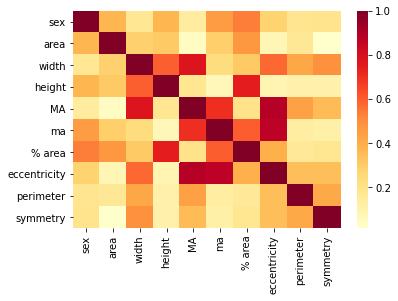

In [5]:
#Load file data
file_data = pd.read_csv(os.path.join("..", 'data', 'id_weight_sex_uuid_data.csv'), usecols=['uuid', 'id', 'sex', 'weight', 'area', 'x', 'y', 'width', 'height', 'MA', 'ma', 'centroid_x', 'centroid_y', 'orientation', '% area', 'center distance', 'eccentricity', 'perimeter', 'symmetry'])
print("Load final data")
display(file_data.head())
#file_data = file_data[file_data['symmetry']>0.65]
file_data = file_data[file_data['area']>150000]
file_data = file_data[file_data['perimeter']>1600]
file_data = shuffle(file_data)

print(len(file_data),"images loaded")

X = file_data.loc[:, 'sex':'symmetry']
print("X data")
display(X.head())

y = file_data.loc[:, ['weight']]
print("y data")
display(y.head())

#Split data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

if PROCESS_DATA:
    print("Correlation matrix")
    corrMatrix = X.corr().abs()
    sn.heatmap(corrMatrix, cmap="YlOrRd")
    plt.savefig(os.path.join("..", 'data', 'heatmap.jpeg'), bbox_inches='tight')
    
    
    scaler = MinMaxScaler()
    dtree = DecisionTreeClassifier()
    linearRegression = LinearRegression()   
    ridge = Ridge()
    ridgecv = RidgeCV()
    lasso = Lasso()
    lassocv = LassoCV()
    lassolars = LassoLars()
    lassolarscv = LassoLarsCV()
    decisionTree = DecisionTreeRegressor()

    pipa = Pipeline(steps=[('scaler', scaler), ('classifier', dtree)])

    param_grid = [{'classifier':[linearRegression], 'classifier__fit_intercept': [True,False]},
                      {'classifier':[ridge], 'classifier__fit_intercept': [True,False], 'classifier__alpha': np.arange(0.5,2.5,0.1)},
                      {'classifier':[ridgecv], 'classifier__fit_intercept': [True,False], 'classifier__scoring':['r2']},
                      {'classifier':[lasso], 'classifier__fit_intercept': [True,False], 'classifier__alpha': np.arange(0.5,2.5,0.1), 'classifier__selection':['cyclic', 'random']},
                      {'classifier':[lassocv], 'classifier__fit_intercept': [True,False], 'classifier__selection':['cyclic', 'random']},
                      {'classifier':[lassolars], 'classifier__fit_intercept': [True,False], 'classifier__alpha': np.arange(0.5,2.5,0.1)},
                      {'classifier':[lassolarscv], 'classifier__fit_intercept': [True,False]},
                      {'classifier':[decisionTree], 'classifier__criterion':['mse', 'friedman_mse', 'mae'], 'classifier__max_features': ['auto', 'sqrt', 'log2']}
                 ]

    scoring_methods = ['r2', 'explained_variance', 'max_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 
                       'neg_root_mean_squared_error', 'neg_median_absolute_error']
    gs = GridSearchCV(estimator=pipa,
                      param_grid=param_grid,
                      #cv=10,
                      refit='r2',
                      return_train_score=True,
                      n_jobs=30,
                      pre_dispatch=30,
                      scoring=scoring_methods,
                      iid=False)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        gs.fit(X_train, y_train.values.ravel())

    joblib.dump({'gs': gs,
                 'scaler': scaler,
                 'linearRegression': linearRegression,
                 'ridge': ridge,
                 'ridgecv': ridgecv,
                 'lasso': lasso,
                 'lassocv': lassocv,
                 'lassolars': lassolars,
                 'lassolarscv': lassolarscv,
                 'decisionTree': decisionTree
                }, 
                os.path.join("..", 'data', datetime.datetime.now().strftime("%Y%m%d%H%M")+'_model.joblib_dump'))
else:
    #Load last model
    os.chdir(os.path.join("..", 'data'))
    files = glob.glob("*.joblib_dump")
    files.sort(reverse=True)
    models = joblib.load(files[0])
    gs = models['gs']
    scaler = models['scaler']
    linearRegression = models['linearRegression']
    ridge = models['ridge']
    ridgecv = models['ridgecv']
    lasso= models['lasso']
    lassocv = models['lassocv']
    lassolars = models['lassolars']
    lassolarscv = models['lassolarscv']
    decisionTree = models['decisionTree']

In [6]:
best_estimator = gs.best_estimator_
print('Best model:', best_estimator.named_steps.classifier)

resultados = pd.DataFrame(gs.cv_results_)
resultados['param_classifier'] = resultados.param_classifier.astype(str).str.split('(', expand=True)[0]
resultados.head()
mejores_resultados_por_tipo_de_modelo = pd.pivot_table(data=resultados,
               index='param_classifier',
               values = ['mean_test_r2', 'std_test_r2',
                            'mean_test_explained_variance', 'std_test_explained_variance',
                            'mean_test_max_error', 'std_test_max_error',
                            'mean_test_neg_mean_absolute_error', 'std_test_neg_mean_absolute_error',
                            'mean_test_neg_mean_squared_error', 'std_test_neg_mean_squared_error', 
                             'mean_test_neg_root_mean_squared_error'
                        ],
               aggfunc='max'
              ).reindex(['mean_test_r2', 'mean_test_explained_variance', 'mean_test_max_error', 'mean_test_neg_mean_absolute_error',
                         'mean_test_neg_root_mean_squared_error', 'std_test_r2', 'std_test_explained_variance', 'std_test_max_error', 'std_test_neg_mean_absolute_error',
                        ], axis=1)
print('Mean scores during Cross Validation')
mejores_resultados_por_tipo_de_modelo.sort_values(by='mean_test_r2', ascending=False, inplace=True)
(mejores_resultados_por_tipo_de_modelo).round(4)

Best model: DecisionTreeRegressor(criterion='friedman_mse', max_features='auto')
Mean scores during Cross Validation


,mean_test_r2,mean_test_explained_variance,mean_test_max_error,mean_test_neg_mean_absolute_error,mean_test_neg_root_mean_squared_error,std_test_r2,std_test_explained_variance,std_test_max_error,std_test_neg_mean_absolute_error
param_classifier,,,,,,,,,
DecisionTreeRegressor,0.9617,0.9618,-7.3600,-0.1516,-0.8763,0.0474,0.0473,2.5664,0.1190
LassoLarsCV,0.8310,0.8312,-6.7597,-1.3365,-1.8473,0.0216,0.0216,0.6757,0.0762
LinearRegression,0.8310,0.8312,-6.7597,-1.3365,-1.8473,0.0216,0.0216,0.6757,0.0766
LassoCV,0.8307,0.8309,-6.7144,-1.3410,-1.8489,0.0210,0.0210,0.6942,0.0499
RidgeCV,0.8287,0.8290,-6.7237,-1.3532,-1.8599,0.0206,0.0206,0.7075,0.0671
Ridge,0.8142,0.8146,-6.7838,-1.4093,-1.9384,0.0183,0.0182,0.7374,0.0657
Lasso,0.5900,0.6241,-7.6328,-2.2867,-2.8793,0.1573,0.1186,1.6685,0.3092
LassoLars,0.5899,0.6240,-8.3471,-2.2873,-2.8797,0.1572,0.1189,1.6665,0.3088


In [7]:
from sklearn.metrics import r2_score, explained_variance_score, max_error, mean_absolute_error
best_estimator_predictions = best_estimator.predict(X_test)
print('R2 score:', r2_score(y_test, best_estimator_predictions))
print('Explained variance score:', explained_variance_score(y_test, best_estimator_predictions))
print('Max error:', max_error(y_test, best_estimator_predictions))
print('Mean absolute error:', mean_absolute_error(y_test, best_estimator_predictions))

R2 score: 0.9585105355590767
Explained variance score: 0.9585106708174351
Max error: 8.3
Mean absolute error: 0.14866310160428983


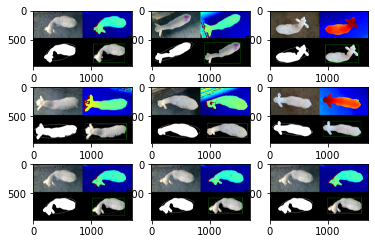

In [8]:
files = []
differences = []
for i in range(0,len(best_estimator_predictions)):
    difference = abs(best_estimator_predictions[i]-y_test.iloc[i].weight) 
    if difference>2:
        uuid = file_data.loc[y_test.iloc[i].name].uuid
        files.append(uuid)
        differences.append({uuid:difference})
"""
print(differences)
print(dif_total)

file_data_new = file_data[file_data['uuid'].isin(files)]
display(file_data_new)
"""

max_images = 9 if (len(files)>9)  else len(files)
for i in range(0,max_images):
    plt.subplot(3,3,i+1)
    img=mpimg.imread(os.path.join("..", 'data', 'mosaic', files[i]+'_mosaico.png'))
    imgplot = plt.imshow(img)

plt.savefig(os.path.join("..", 'data', 'mismatch.jpeg'), bbox_inches='tight')

In [9]:
print(differences)
means = file_data.mean()
display(means)
file_data_new = file_data[file_data['uuid'].isin(files)]
display(file_data_new)

[{'f43982ea6a9e45a1a99da3e2f00a3669': 6.5}, {'6719bc80004342dea53c5f3765e44965': 8.3}, {'90644fa9af6f4d70a3495c1a689463e0': 6.600000000000001}, {'0a3c9144c3d2411c8c0f50311c2639b4': 6.600000000000005}, {'ca61cb45adbd4c3a9ee4166d7c014a71': 6.299999999999999}]


sex                     0.720706
area               247690.909288
width                 599.774478
height                321.871589
MA                    620.007148
ma                    245.300325
% area                 47.774639
eccentricity            0.902990
perimeter            1754.722833
symmetry                0.274542
weight                 23.131942
x                     155.693419
y                      91.554575
centroid_x            244.403513
centroid_y            460.267328
center distance        55.548678
orientation            -0.158154
dtype: float64

,uuid,id,sex,area,width,height,MA,ma,% area,eccentricity,perimeter,symmetry,weight,x,y,centroid_x,centroid_y,center distance,orientation
568,90644fa9af6f4d70a3495c1a689463e0,TA5751,1,251445.721146,689,242,699.866638,227.804901,58.149679,0.945543,1741.148399,0.303974,26.8,114,147,261.513822,489.728039,69.159378,1.500539
872,6719bc80004342dea53c5f3765e44965,CG1741,0,233896.198850,711,273,770.697876,234.175888,53.305238,0.952720,1970.729133,0.239143,27.2,43,144,279.678486,390.759053,51.762368,-1.523603
435,f43982ea6a9e45a1a99da3e2f00a3669,TA433,0,233008.125779,608,360,710.979431,168.946289,31.953718,0.971357,1709.616436,0.259582,17.7,73,74,234.491425,401.431246,23.231295,-1.175338
656,0a3c9144c3d2411c8c0f50311c2639b4,TA0160,1,246726.271224,581,270,560.240356,239.338715,53.236553,0.904154,1765.581946,0.286754,20.2,141,102,226.044258,453.932445,33.025959,-1.465574
1605,ca61cb45adbd4c3a9ee4166d7c014a71,TA0160,1,210053.410915,581,270,560.240356,239.338715,53.236553,0.904154,1765.581946,0.286754,20.2,141,102,226.044258,453.932445,33.025959,-1.465574
